In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
mnist = np.genfromtxt('MNIST_Shortened.csv', delimiter=',', skip_header=1)


In [3]:
# Define X and Y

X = mnist[:,0:784]
y = mnist[:,-1]

# Check dimensions of X
print(X.shape)

(6000, 784)


<function matplotlib.pyplot.show(close=None, block=None)>

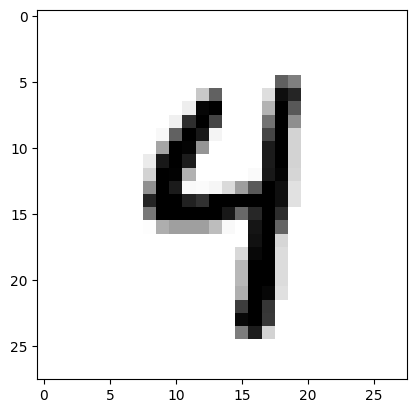

In [4]:
# We can use the Numpy reshape functio along with the matplotlib imshow function to visualize

plt.imshow(X[5632].reshape(28,28), cmap='gray_r')
plt.show

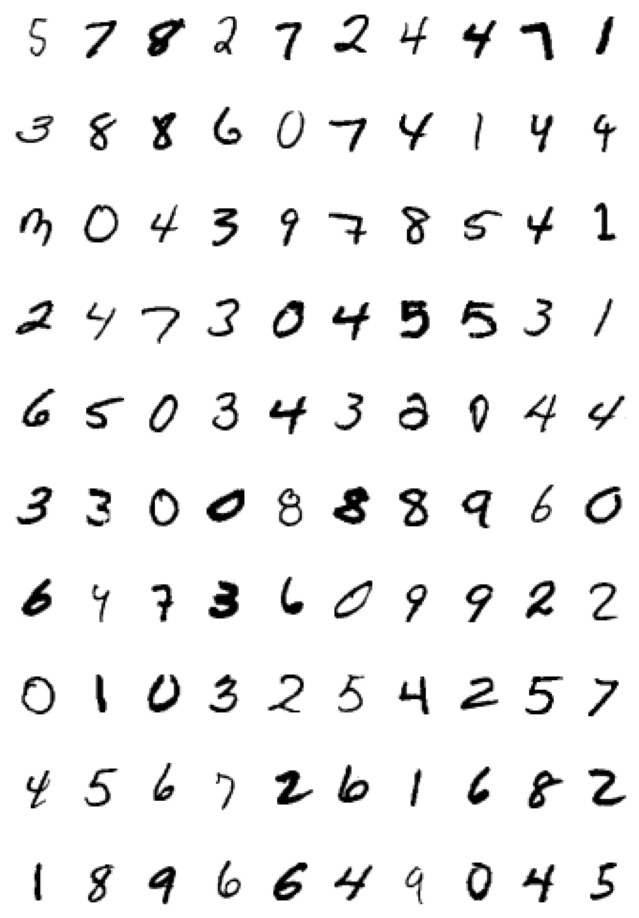

In [5]:
plt.figure(figsize=(8, 12))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(X[np.random.randint(0,6000)].reshape(28,28),cmap='gray_r')
    plt.axis('off')
plt.show()


In [6]:
# Split data into train and test sets

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0, stratify=y)

In [7]:
from sklearn.feature_selection import VarianceThreshold

variance_selector = VarianceThreshold(threshold=0)

x_train_fs = variance_selector.fit_transform(x_train)
x_test_fs = variance_selector.transform(x_test)

print(f"{x_train.shape[1] - x_test_fs.shape[1]} features have been removed, {x_train_fs.shape[1]} features remain")

118 features have been removed, 666 features remain


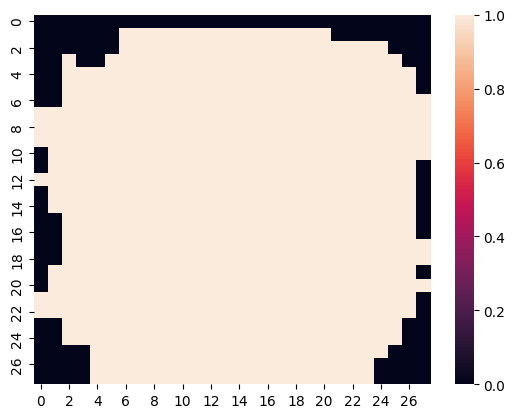

In [8]:
# We can use the get_support function to see which features have been dropped

selected_features = variance_selector.get_support()

selected_features = selected_features.reshape(28,28)

# Visualise which pixels have been dropped

sns.heatmap(selected_features, cmap='rocket')

plt.show()

In [9]:
# Use the SelectKBest selector from sklearn to select the k features with the best scores on a selected test statistic

from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k = 200)

x_train_fs = selector.fit_transform(x_train_fs, y_train)
x_test_fs = selector.transform(x_test_fs)

In [11]:
# Create boolean array for all features

new_features_indices =  variance_selector.get_support(indices=True)[selector.get_support()]
new_features_boolean = np.isin(np.arange(784), new_features_indices)

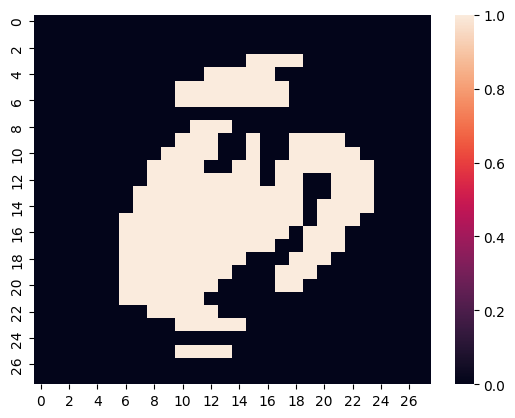

In [12]:
# Reshape and plot as a heatmap

sns.heatmap(new_features_boolean.reshape(28,28), cmap='rocket')

plt.show()

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import RFECV

In [14]:
# Standardise data before passing to model

scaler = StandardScaler()
x_train_fs = scaler.fit_transform(x_train_fs)
x_test_fs = scaler.transform(x_test_fs)

In [15]:
rf = RandomForestClassifier(random_state=0) # Use RandomForestClassifier as the base model

rfecv = RFECV(rf, cv = 3, step=5)

x_train_fs = rfecv.fit_transform(x_train_fs, y_train)
x_test_fs = rfecv.transform(x_test_fs)

print(f"Number of remaining features: {x_train_fs.shape[1]}")

Number of remaining features: 170


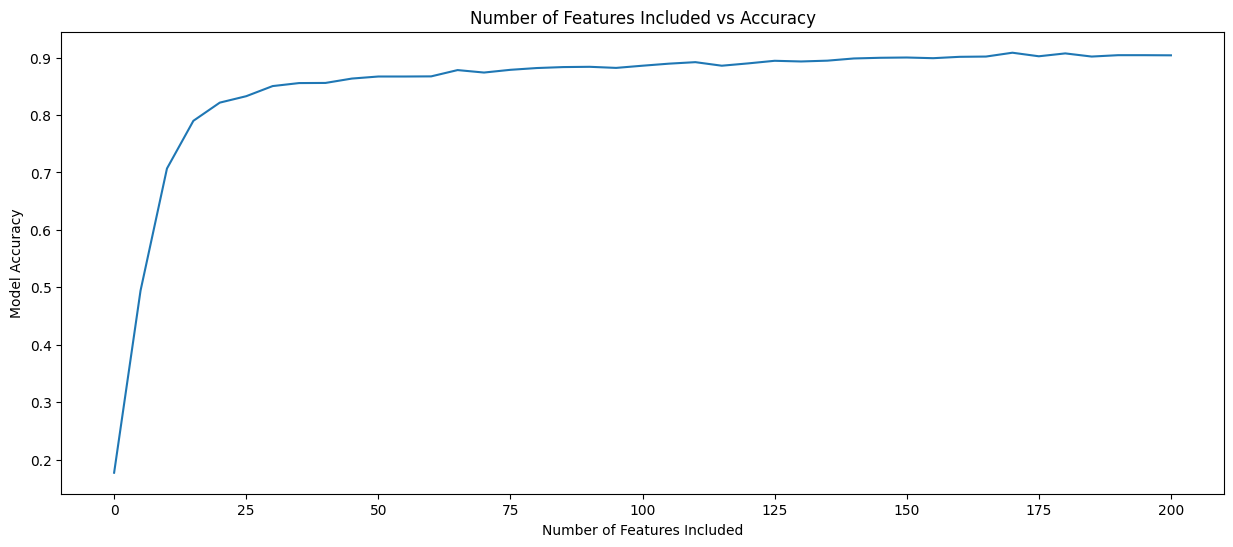

In [16]:
plt.figure( figsize=(15, 6))
plt.title('Number of Features Included vs Accuracy')
plt.xlabel('Number of Features Included')
plt.ylabel('Model Accuracy')
plt.plot(np.linspace(0,200,41), rfecv.cv_results_['mean_test_score'])
plt.show()

In [17]:
rf_selectedfeatures = RandomForestClassifier()
rf_selectedfeatures.fit(x_train_fs, y_train)

RandomForestClassifier()

Accuracy Score: 91.22%


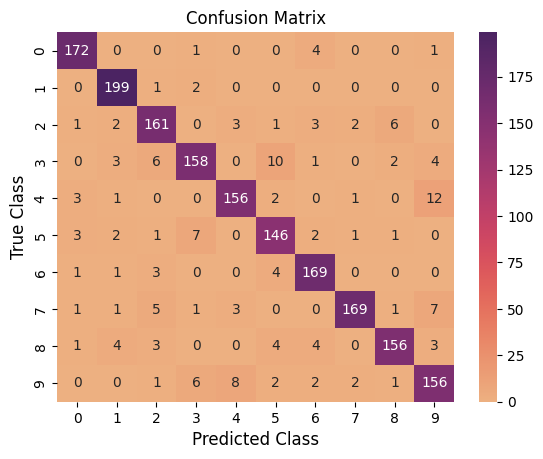

In [18]:
# Make predictions on the test data
y_pred = rf_selectedfeatures.predict(x_test_fs)

print(f"Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.2f}%")

cm = confusion_matrix(y_test,y_pred)

ax = sns.heatmap(cm, cmap='flare', annot=True, fmt='d')


plt.xlabel("Predicted Class", fontsize=12)
plt.ylabel("True Class", fontsize=12)
plt.title("Confusion Matrix", fontsize=12)
plt.show()